# Damped Newton's method for root finding (Jacobian version)

This example shows a basic implementation of the Damped Newton's root-finding method applied on a vector function of a vector variable. 

In [1]:
# multimodal function
import numpy as np
import matplotlib.pyplot as plt

## The function 

Vector function of a vector variable ${\bf f}(x,y) = (u,v)$, where: 

$$
\begin{align}
    u &= x^2 - y^2 - 4 \\
    v &= 2\,x\,y. 
\end{align}
$$

We can also denote the function as ${\bf u}({\bf x})$ or ${\bf f}({\bf x})$, where ${\bf x} = (x,y)^\mathsf{T}$ and ${\bf u} = (u,v)^\mathsf{T}$.

In [243]:
def f(x):
    """Computes the value of the function at x
    
    Args:
        x (np.ndarray): A 2x1 column matrix containing (x,y)
 
    Returns:
        u (np.ndarray): A 2x1 column matrix containing (u,v)
    """
    
    # Assign the x and y coordinates 
    xi = x[0][0]   # x-value 
    yi = x[1][0]   # y-value 
    
    # Calculate the value of the function at (x,y)
    ui = xi**2 - yi**2 - 4   # u-value
    vi = 2 * xi * yi         # v-value 
    
    u = np.array([[ui],[vi]])     
    return u

In [3]:
def create_function_plot(): 
    """Creates the function plot. We can add more features to the plot as needed prior 
    to showing the plot. 
    """

    xi,yi = np.meshgrid(np.linspace(-10,10,20),np.linspace(-10,10,20))

    ui = xi**2 - yi**2 - 4   # u-value
    vi = 2 * xi * yi         # v-value 

    plt.quiver(xi,yi,ui,vi,color='r')

    plt.streamplot(xi, yi, ui, vi, color='gray', linewidth=1, cmap=plt.cm.inferno,
                  density=2, arrowstyle='->', arrowsize=1.5)
    
    # Suggestion for font type in plots from: 
    # https://matplotlib.org/stable/gallery/text_labels_and_annotations/text_fontdict.html
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }

    plt.title('$f(x,y) = (u, v)$', fontdict=font)
    plt.xlabel('$x$', fontdict=font)
    plt.ylabel('$y$', fontdict=font)
    
    return plt

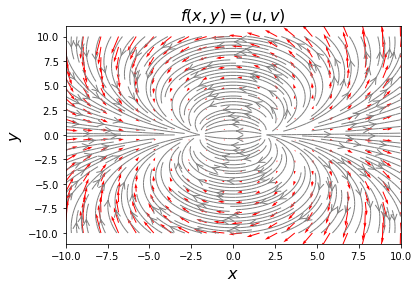

In [4]:
create_function_plot()
plt.show()

## Derivative (first-order variation)

The Newton's root-finding algorithm iterates by moving in a direction guided by the slope of the function at the current location. The slope is a locally linear approximation of the function, and is obtained by calculating the first-order derivative of the function. The derivative (i.e., Jacobian) of the function used in these notes is given by:

$$
\begin{align}
\frac{d{\bf u}}{d{\bf x}} = \frac{\partial(u,v)}{\partial(x,y)} = J = 
\begin{bmatrix}
    \frac{du}{dx} & \frac{du}{dy} \\
    \frac{dv}{dx} & \frac{dv}{dy} 
\end{bmatrix}
= 
\begin{bmatrix}
    2x & -2y \\
    2y &  2x 
\end{bmatrix}.
\label{JacobianAnalytical}
\end{align}
$$

In [242]:
def Jacobian(x):
    """Computes the Jacobian of the function at x
    
    Args:
        x (np.ndarray): A 2x1 column matrix containing (x,y)
 
    Returns:
        u (np.ndarray): A 2x2 matrix containing the Jacobian
    """
    
    xi = x[0][0]   # x-value 
    yi = x[1][0]   # y-value 
    
    dudx =  2*xi
    dudy = -2*yi
    dvdx =  2*yi
    dvdy =  2*xi
    
    J = np.array([[dudx, dudy],
                  [dvdx, dvdy]])
    return J

## Numerical approximation of the Jacobian
It is common for the Jacobian in Equation $\ref{JacobianAnalytical}$ to be calculated numerically instead of analytically. The numerical calculation uses finite differences and ratios. 

$$
\begin{align}
J = 
\begin{bmatrix}
    \frac{du}{dx} & \frac{du}{dy} \\
    \frac{dv}{dx} & \frac{dv}{dy} 
\end{bmatrix}
\approx 
          \begin{bmatrix}
          	 \dfrac{\Delta{\bf u}}{\Delta x}  & 
             \dfrac{\Delta{\bf u}}{\Delta y} 
          \end{bmatrix}    
          =
          \begin{bmatrix}
          	  \dfrac{\Delta u}{\Delta x}  & \dfrac{\Delta u}{\Delta y}\\[1em]
          	 \dfrac{\Delta v}{\Delta x}  & \dfrac{\Delta v}{\Delta y} 
	 \end{bmatrix}.          
\label{JacobianApproximation}
\end{align}
$$

Here, the elements of the matrix in ($\ref{JacobianApproximation}$) are calculated using forward finite differences, i.e.: 

$$
\begin{align}
        \frac{\Delta {\bf u}}{\Delta x} = 
        \frac{{\bf u}\left({\bf x}+\Delta {x}\right) - {\bf u}\left({\bf x}\right)}{\delta x}   = 
        \frac{
           {\bf u}\left(
           \begin{bmatrix}
                x\\   y
           \end{bmatrix}
          +
           \begin{bmatrix}
                \delta x\\   0
           \end{bmatrix}      
          \right) - {\bf u}\left({\bf x}\right)     
        }{\delta x}      
	\label{approxExample2}
\end{align}	
$$

and 

$$
\begin{align}
       \frac{\Delta {\bf u}}{\Delta y} = \frac{{\bf u}\left({\bf y}+\Delta {y}\right) - {\bf u}\left({\bf x}\right)}{\delta y}
       =
        \frac{
           {\bf u}\left(
           \begin{bmatrix}
                x\\   y
           \end{bmatrix}
          +
           \begin{bmatrix}
                0\\   \delta y
           \end{bmatrix}      
          \right)      
        - {\bf u}\left({\bf x}\right)}{\delta y}      
	\label{approxExample3}
\end{align}	
$$

for a small $\delta x$ and $\delta y$.  

In [274]:
def JacobianApprox(x, function, dx, dy):
    """Computes the Jacobian numerically 
    
    Args:
        x (np.ndarray): A 2x1 column matrix containing (x,y)
 
    Returns:
        u (np.ndarray): A 2x2 matrix containing the Jacobian
    """
    
    xi = x[0][0]   # x-value 
    yi = x[1][0]   # y-value 
    
    
    delta_x = np.array([[dx],[0]]) 
    delta_y = np.array([[0],[dy]]) 
    
    DuDx = (f(x + delta_x) - f(x)) / dx 
    DuDy = (f(x + delta_y) - f(x)) / dy 
    
    J = np.concatenate((DuDx,DuDy), axis=1)

    return J

### Example 1
The value of the function at ${\bf x} = (0,0)^\mathsf{T}$ is ${\bf u}({\bf x}) = (-4, 0)^\mathsf{T}$. 

In [239]:
x = np.array([[0],[0]])
print('f(x)=', np.array2string(f(x), prefix='Array:'))

f(x)= [[-4]
       [ 0]]


The following plot shows the location of the point.

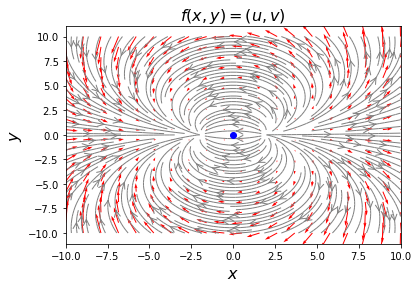

In [240]:
create_function_plot()
plt.plot(x[0][0], x[1][0], 'bo')
plt.show()

Its derivative is given by: 

In [8]:
print('J(x)=', np.array2string(Jacobian(x), prefix='Array:'))

J(x)= [[0 0]
       [0 0]]


This Jacobian is the Zero matrix. It means that there is no variation in ${\bf u}=(u,v)^\mathsf{T}$ around the point ${\bf x} = (x,y)^\mathsf{T}$. 

### Example 2
Let's calculate the Jacobian at another location, i.e., ${\bf x} = (-7.5,0.0)^\mathsf{T}$. At this location, the value of the function is:

In [9]:
x = np.array([[-7.5],[0]])
print('f(x)=', np.array2string(f(x), prefix='Array:'))

f(x)= [[52.25]
       [-0.  ]]


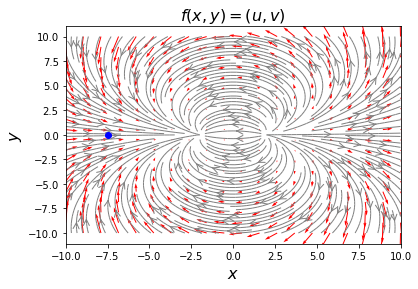

In [10]:
create_function_plot()
plt.plot(x[0][0], x[1][0], 'bo')
plt.show()

Its derivative is: 

In [11]:
print('J(x)=', np.array2string(Jacobian(x), prefix='Array:'))

J(x)= [[-15.  -0.]
       [  0. -15.]]


This Jacobian indicates that the rate of change of $u$ is -15 in the $x$-direction, and 0 in the $y$-direction. Also, the rate of change of $v$ is 0 in the $x$-direction, and -15 in the $y$-direction. 

### Example 3
Calculating the Jacobian at another location. The location is ${\bf x} = (3,2)^\mathsf{T}$.

In [12]:
x = np.array([[3],[2]])
print('f(x)=', np.array2string(f(x), prefix='Array:'))

f(x)= [[ 1]
       [12]]


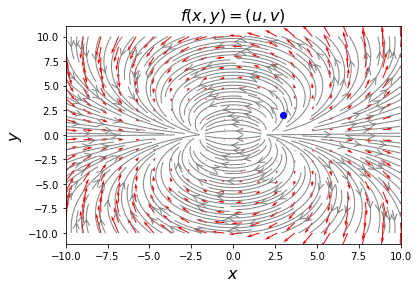

In [13]:
create_function_plot()
plt.plot(x[0][0], x[1][0], 'bo')
plt.show()

In [14]:
print('J(x)=', np.array2string(Jacobian(x), prefix='Array:'))

J(x)= [[ 6 -4]
       [ 4  6]]


This Jacobian tells us that the rate of change of $u$  is 6 in the $x$-direction and -4 in the $y$-direction. Also, the rate of change of $v$ is 4 in the $x$-direction and 6 in the $y$-direction. 

## Local approximation of function value using the derivative 
The ability of approximate a function locally using first-order derivatives is very useful and it is part of the background needed to understand the details of the Newton's root-finding algorithm. If we select a (small) step $\Delta x$ then the linear approximation of the value of the function at a point $x+\Delta x$ is given by:

$$
f(x+\Delta x) = f(x) + \frac{df}{dx} \cdot \Delta x
$$
for a scalar function of a single scalar variable.

For a vector function of a vector variable, the approximation is given by:

$$
\begin{align}
{\bf f}({\bf x}+\Delta {\bf x}) &= {\bf f}({\bf x}) + \frac{d{\bf f}}{d{\bf x}} \cdot \Delta {\bf x}\\
&= {\bf f}({\bf x}) + J \cdot \Delta {\bf x}\\
&= {\bf f}({\bf x}) +
\begin{bmatrix}
    \frac{du}{dx} & \frac{du}{dy} \\
    \frac{dv}{dx} & \frac{dv}{dy} 
\end{bmatrix} 
\cdot
\Delta x.
\end{align}
$$

### Example 
Consider the value of the function at ${\bf x} = (3,2)^\mathsf{T}$. 

In [15]:
x = np.array([[3],[2]])
print('f(x)=', np.array2string(f(x), prefix='Array:'))

f(x)= [[ 1]
       [12]]


Let's choose a small step in ${\bf x}$, e.g., $\Delta x = (.1,.1)^\mathsf{T}$:

In [16]:
# Delta x 
delta_x = np.array([[.1],[.1]])
print('Delta_x =', np.array2string(delta_x, prefix='Array:    '))

Delta_x = [[0.1]
           [0.1]]


Where, we want to determine the value of $f({\bf x} + \Delta x)$.

In [17]:
J = Jacobian(x)

f_predicted = f(x) + J @ delta_x
print('Predicted:')
print('f(x + delta_x) =', np.array2string(f_predicted, prefix='Array:           '))

f_actual = f(x + delta_x)
print('Actual:')
print('f(x + delta_x) =', np.array2string(f_actual, prefix='Array:           '))

Predicted:
f(x + delta_x) = [[ 1.2]
                  [13. ]]
Actual:
f(x + delta_x) = [[ 1.2 ]
                  [13.02]]


For $\Delta x = (.1,.1)^\mathsf{T}$, the locally linear approximation (i.e., predicted value) is quite close to the actual function value. Next, we test the approximation for a larger value of $\Delta x$, say $\Delta x = (2,2)^\mathsf{T}$.

In [18]:
# Delta x 
delta_x = np.array([[2],[2]])
print('Delta_x =', np.array2string(delta_x, prefix='Array:    '))

Delta_x = [[2]
           [2]]


In [19]:
J = Jacobian(x)

f_predicted = f(x) + J @ delta_x
print('Predicted:')
print('f(x + delta_x) =', np.array2string(f_predicted, prefix='Array:           '))

f_actual = f(x + delta_x)
print('Actual:')
print('f(x + delta_x) =', np.array2string(f_actual, prefix='Array:           '))

Predicted:
f(x + delta_x) = [[ 5]
                  [32]]
Actual:
f(x + delta_x) = [[ 5]
                  [40]]


The above example shows that the linear approximation provided by the first-order derivative is only in the vincinity of the point at which the derivative was calculated. In this case specifically, the $v$ coordinate resulted from the approximation is very different from its actual value. 

### Example 

What if we want to calculate the $\Delta x$ for a given variation of the function? In this case, we can calculate the value of the step that will give us to a specific value of the function, say $f({\bf x_g})$. Thus, we want to calculate $\Delta x$ that gives us $f({\bf x} + \Delta x) = (u,v)^\mathsf{T}$. 

Here, we will start at ${\bf x} = (7.5,7.5)^\mathsf{T}$. We then calculate the step in $f$, i.e., $\Delta f = f({\bf x}) - f({\bf x_g})$. This is a step in $f$. To find out the corresponding step in $x$, we calculate the variation $\Delta x$ by mapping $\Delta f$ through the inverse Jacobian, i.e., $\Delta {\bf x} = J^{-1}\Delta f$. 

In [20]:
# Current function value
x = np.array([[7.5],[7.5]])
print('f(x) =', np.array2string(f(x), prefix='Array: '))

f(x) = [[ -4. ]
        [112.5]]


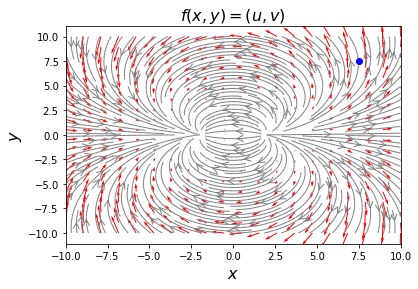

In [21]:
create_function_plot()
plt.plot(x[0][0], x[1][0], 'bo')
plt.show()

In [22]:
# Some goal location and its function value (we will use the function value)
# This is just a test location so we can get a function value. We don't know the location. 
# We only know the target value. 
xg = np.array([[3],[-10]])   

# The goal function value we want to achieve
uv_g = f(xg)
print('The function value (goal) we want to achieve:')
print('f(xg) =', np.array2string(uv_g, prefix='Array:  '))

The function value (goal) we want to achieve:
f(xg) = [[-95]
         [-60]]


In [23]:
# Delta f 
delta_f = uv_g - f(x)  # The difference (error) between the current value 
                       # and the target value.
print('delta_f =', np.array2string(delta_f, prefix='Array:    '))

delta_f = [[ -91. ]
           [-172.5]]


In [24]:
# Jacobian at x (i.e., linear local approximation of the function at location x)
J = Jacobian(x)
print('J(x) =', np.array2string(J, prefix='Array: '))

J(x) = [[ 15. -15.]
        [ 15.  15.]]


In [25]:
# Inverse Jacobian (This is dx/df instead of df/dx)
Jinv = np.linalg.inv(J)
print('Jinv(x) =', np.array2string(Jinv, prefix='Array:    '))

Jinv(x) = [[ 0.03333333  0.03333333]
           [-0.03333333  0.03333333]]


In [26]:
# Delta_x for the given Delta_f using the inverse Jacobian
delta_x_mapped = Jinv @ delta_f
print('Delta_x (mapped)=', np.array2string(delta_x_mapped, prefix='Array:            '))

Delta_x (mapped)= [[-8.78333333]
                   [-2.71666667]]


In [27]:
print('x + delta_x_mapped=', np.array2string(x + delta_x_mapped, prefix='Array:              '))

# Predicted function f(x + delta_x)
f_predicted = f(x + delta_x_mapped)
print('f(x + delta_x) predicted=', np.array2string(f_predicted, prefix='Array:                    '))

x + delta_x_mapped= [[-1.28333333]
                     [ 4.78333333]]
f(x + delta_x) predicted= [[-25.23333333]
                           [-12.27722222]]


The predicted value is not even close to the target value. But, we did not expected to get the correct value because we are using a locally linear approximation of the function. So, instead of trying to go straight to the target value, we take a small step in the correct direction provided by the calculated $\Delta {\bf x} = J^{-1}\Delta f$. 

In [28]:
# Scale down the step for delta x 
delta_x_mapped_slow = 0.5 * delta_x_mapped
print('Delta_x (scaled)=', np.array2string(delta_x_mapped_slow, prefix='Array:            '))

Delta_x (scaled)= [[-4.39166667]
                   [-1.35833333]]


In [29]:
# Function value at updated scaled down location  
f_predicted_slow = f(x + delta_x_mapped_slow)
print('x + delta_x_scaled=', np.array2string(x + delta_x_mapped_slow, prefix='Array:              '))

# Predicted function f(x + delta_x)
f_predicted = f(x + delta_x_mapped)
print('f(x + delta_x) scaled=', np.array2string(f_predicted_slow, prefix='Array:                 '))

x + delta_x_scaled= [[3.10833333]
                     [6.14166667]]
f(x + delta_x) scaled= [[-32.05833333]
                        [ 38.18069444]]


Once we get the fraction of the step, we can move forward towards the target value by repeating the calculations and updating the new locations and new values. The updated location is as follows:

In [30]:
# Updated location
x = x + delta_x_mapped_slow
x

array([[3.10833333],
       [6.14166667]])

The steps describe the iterations of the Newton's root-finding algorithm for the case when we want to achieve a given value of the function. 

### Basic implementation of the Newton's root-finding

In [275]:
# Current function value
x = np.array([[9.5],[5]])
print('\nThe function value at the current location:')
print('f(x) =', np.array2string(f(x), prefix='Array: '))

# The goal function value we want to achieve
uv_g = f(xg)
print('\nThe function value (goal) we want to achieve:')
print('f(xg) =', np.array2string(uv_g, prefix='Array:  '))


The function value at the current location:
f(x) = [[61.25]
        [95.  ]]

The function value (goal) we want to achieve:
f(xg) = [[-95]
         [-60]]


In [ ]:
# Newton's root-finding


xtrace = x                      # Stores the trajectory in x-domain
delta_f = uv_g - f(x)           # Difference between predicted and target 
dist = np.linalg.norm(delta_f)  # Error measure (distance)
table = []                      # Table to store the iteration results                        

it = 0                          # Iteration count 

# Delta f 
while dist > 0.1:    
    delta_f = uv_g - f(x)
    dist = np.linalg.norm(delta_f)

    # Jacobian at x
#    J = Jacobian(x)                       # Analytical Jacobian when available
    J = JacobianApprox(x, f, .1, .1)       # Numerica Jacobian 

    # Inverse Jacobian
    Jinv = np.linalg.inv(J)

    # Delta x for the Delta f using the inverse Jacobian
    delta_x_mapped = Jinv @ delta_f

    # Predicted function f(x + delta_x)
    f_predicted = f(x + delta_x_mapped)

    # The goal function value we want to achieve
    uv_g = f(xg)

    # Scale down the step for delta x 
    delta_x_mapped_slow = 0.05 * delta_x_mapped

    # Function value at updated scaled down location  
    f_predicted_slow = f(x + delta_x_mapped_slow)
    
    table.append([dist, uv_g, f_predicted,x])

    x = x + delta_x_mapped_slow
    
    # Save iteration result  
    xtrace = np.append(xtrace, x, axis=1)

    it +=1    

In [277]:
import pandas as pd
df = pd.DataFrame(table, columns = ['Error', 'f(x) target', 'f(x) predicted', 'x'])
df

,Error,f(x) target,f(x) predicted,x
0,220.088761,"[[-95], [-60]]","[[-7.870678369527997], [-1.0893406283298723]]","[[9.5], [5.0]]"
1,209.365496,"[[-95], [-60]]","[[-7.149188381204327], [-2.9764080065662393]]","[[9.011290148738953], [4.849320974347919]]"
2,199.176735,"[[-95], [-60]]","[[-5.928717339173979], [-4.8846608236096385]]","[[8.522255115876863], [4.70356558832858]]"
3,189.496717,"[[-95], [-60]]","[[-4.127786174650543], [-6.878208127134259]]","[[8.031693388812691], [4.563126230405582]]"
4,180.301026,"[[-95], [-60]]","[[-1.6433049886721678], [-9.051611151132152]]","[[7.538241907613927], [4.4285593228754445]]"
...,...,...,...,...
147,0.122026,"[[-95], [-60]]","[[-94.99925340788123], [-60.00002528943665]]","[[-2.99762999737287], [9.994656399560972]]"
148,0.115954,"[[-95], [-60]]","[[-94.99928958540403], [-60.00002282490686]]","[[-2.997749069220174], [9.994921884614865]]"
149,0.110184,"[[-95], [-60]]","[[-94.99932405966089], [-60.00002060061438]]","[[-2.99786215692949], [9.995174176696418]]"
150,0.104701,"[[-95], [-60]]","[[-94.99935690588961], [-60.0000185931324]]","[[-2.997969561430716], [9.995413931712962]]"


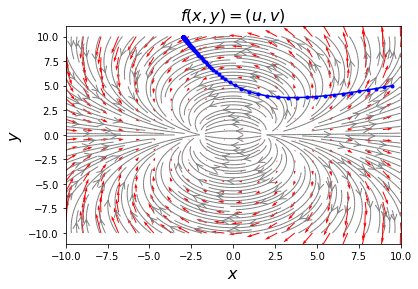

In [278]:
create_function_plot()
plt.plot(xtrace[0][:], xtrace[1][:], 'b.-')
plt.show()

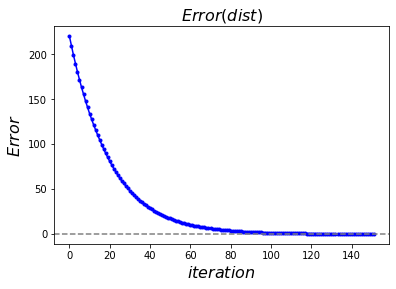

In [279]:
###--------------------------------------------------------###
#              Plot error curve
###--------------------------------------------------------###
# Error values 
error = [row[0] for row in table]
plt.plot(error, 'b.-')

# draw a horizontal line at the optimal point
plt.axhline(y=0, ls='--', color='gray')

# Suggestion for font type in plots from: 
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/text_fontdict.html
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

plt.title('$Error (dist)$', fontdict=font)
plt.xlabel('$iteration$', fontdict=font)
plt.ylabel('$Error$', fontdict=font)

plt.show()

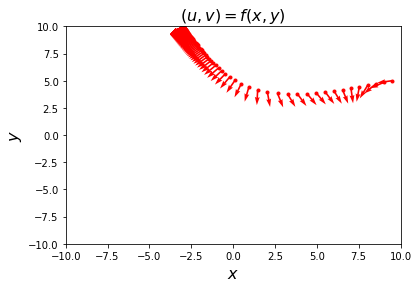

In [280]:
###--------------------------------------------------------###
#              Plot f(x) sequence 
###--------------------------------------------------------###
# f(x) values 
ui = np.array([row[2][0][0] for row in table])
vi = np.array([row[2][1][0] for row in table])

ui_unit = ui / np.sqrt(ui**2 + vi**2)
vi_unit = vi / np.sqrt(ui**2 + vi**2)


xi = np.array([row[3][0][0] for row in table])
yi = np.array([row[3][1][0] for row in table])

plt.quiver(xi,yi,ui_unit,vi_unit,color='r')
plt.plot(xi,yi,'r.')

plt.title('$(u,v) = f(x,y)$', fontdict=font)
plt.xlabel('$x$', fontdict=font)
plt.ylabel('$y$', fontdict=font)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

plt.show()